In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/edgeiiotset-cyber-security-dataset-of-iot-iiot/Edge_IIoTset__DatasetFL.pdf
/kaggle/input/edgeiiotset-cyber-security-dataset-of-iot-iiot/Readme.txt
/kaggle/input/edgeiiotset-cyber-security-dataset-of-iot-iiot/Edge-IIoTset dataset/Attack traffic/Uploading attack.pcap
/kaggle/input/edgeiiotset-cyber-security-dataset-of-iot-iiot/Edge-IIoTset dataset/Attack traffic/DDoS_ICMP_Flood_attack.csv
/kaggle/input/edgeiiotset-cyber-security-dataset-of-iot-iiot/Edge-IIoTset dataset/Attack traffic/DDoS_TCP_SYN_Flood_attack.csv
/kaggle/input/edgeiiotset-cyber-security-dataset-of-iot-iiot/Edge-IIoTset dataset/Attack traffic/MITM (ARP spoofing + DNS) Attack.pcap
/kaggle/input/edgeiiotset-cyber-security-dataset-of-iot-iiot/Edge-IIoTset dataset/Attack traffic/Uploading_attack.csv
/kaggle/input/edgeiiotset-cyber-security-dataset-of-iot-iiot/Edge-IIoTset dataset/Attack traffic/XSS_attack.csv
/kaggle/input/edgeiiotset-cyber-security-dataset-of-iot-iiot/Edge-IIoTset dataset/Attack traffic/DDoS_UD

In [6]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, Conv1D, MaxPooling1D, Flatten, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [7]:
data_path = '/kaggle/input/edgeiiotset-cyber-security-dataset-of-iot-iiot/Edge-IIoTset dataset/Selected dataset for ML and DL/ML-EdgeIIoT-dataset.csv'

df = pd.read_csv(data_path, low_memory=False)

# Basic info
print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"Attack label distribution:\n{df['Attack_label'].value_counts()}")

# Lowercase columns for ease
df.columns = df.columns.str.lower()

Dataset shape: (157800, 63)
Columns: ['frame.time', 'ip.src_host', 'ip.dst_host', 'arp.dst.proto_ipv4', 'arp.opcode', 'arp.hw.size', 'arp.src.proto_ipv4', 'icmp.checksum', 'icmp.seq_le', 'icmp.transmit_timestamp', 'icmp.unused', 'http.file_data', 'http.content_length', 'http.request.uri.query', 'http.request.method', 'http.referer', 'http.request.full_uri', 'http.request.version', 'http.response', 'http.tls_port', 'tcp.ack', 'tcp.ack_raw', 'tcp.checksum', 'tcp.connection.fin', 'tcp.connection.rst', 'tcp.connection.syn', 'tcp.connection.synack', 'tcp.dstport', 'tcp.flags', 'tcp.flags.ack', 'tcp.len', 'tcp.options', 'tcp.payload', 'tcp.seq', 'tcp.srcport', 'udp.port', 'udp.stream', 'udp.time_delta', 'dns.qry.name', 'dns.qry.name.len', 'dns.qry.qu', 'dns.qry.type', 'dns.retransmission', 'dns.retransmit_request', 'dns.retransmit_request_in', 'mqtt.conack.flags', 'mqtt.conflag.cleansess', 'mqtt.conflags', 'mqtt.hdrflags', 'mqtt.len', 'mqtt.msg_decoded_as', 'mqtt.msg', 'mqtt.msgtype', 'mqtt.

In [9]:
object_cols = df.select_dtypes(include=['object']).columns
for col in object_cols:
    if col != 'attack_type':  # Keep attack_type for possible multi-class later
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))

# Features and binary label (like the paper: Normal vs Attack)
X = df.drop(['attack_label', 'attack_type'], axis=1)
y = df['attack_label'].values  # 0 = Normal, 1 = Attack

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [10]:
# Optional: Sample for quick testing (remove for full dataset in your paper)
df_sampled = False
if df_sampled:
    sample_idx = np.random.choice(len(df), size=int(0.2 * len(df)), replace=False)
    X = X[sample_idx]
    y = y[sample_idx]
    print(f"Sampled shape: {X.shape}")

# One-hot encode labels for categorical cross-entropy
y_onehot = tf.keras.utils.to_categorical(y, num_classes=2)

# Train-test split (80/20 stratified)
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, stratify=y_onehot, random_state=42)

# Reshape for LSTM and CNN: (samples, timesteps=1, features) → 3D input
timesteps = 1
features = X_train.shape[1]
X_train_reshaped = X_train.reshape((X_train.shape[0], timesteps, features))
X_test_reshaped = X_test.reshape((X_test.shape[0], timesteps, features))

# Normal data only for Autoencoder (unsupervised anomaly part)
normal_train_mask = np.argmax(y_train, axis=1) == 0
X_train_normal = X_train[normal_train_mask]

print(f"Training samples: {X_train.shape[0]}, Normal for AE: {X_train_normal.shape[0]}")

Training samples: 126240, Normal for AE: 19441


In [16]:
input_flat = Input(shape=(features,))          # For Autoencoder
input_seq = Input(shape=(timesteps, features)) # For LSTM & CNN

# Autoencoder (dimensionality reduction + anomaly features)
encoder = Dense(64, activation='relu')(input_flat)
encoder = Dense(32, activation='relu')(encoder)
latent = Dense(16, activation='relu')(encoder)  # Latent space

decoder = Dense(32, activation='relu')(latent)
decoder = Dense(64, activation='relu')(decoder)
decoded = Dense(features, activation='linear')(decoder)

autoencoder = Model(input_flat, decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [17]:
# Encoder model for feature extraction
encoder_model = Model(input_flat, latent)

# Train Autoencoder on normal data only
autoencoder.fit(X_train_normal, X_train_normal,
                epochs=50,
                batch_size=128,
                validation_split=0.2,
                callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
                verbose=1)

# LSTM branch (temporal patterns)
lstm_branch = LSTM(50, activation='relu', return_sequences=False)(input_seq)
lstm_branch = Dropout(0.3)(lstm_branch)

# CNN branch (spatial/local patterns) - 1D Conv
cnn_branch = Conv1D(64, kernel_size=3, activation='relu', padding='same')(input_seq)
cnn_branch = MaxPooling1D(pool_size=1)(cnn_branch)  # pool_size=1 to keep shape
cnn_branch = Conv1D(32, kernel_size=3, activation='relu', padding='same')(cnn_branch)
cnn_branch = Flatten()(cnn_branch)
cnn_branch = Dropout(0.3)(cnn_branch)

Epoch 1/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.8270 - val_loss: 0.5137
Epoch 2/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6172 - val_loss: 0.3168
Epoch 3/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2600 - val_loss: 0.2517
Epoch 4/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1742 - val_loss: 0.2157
Epoch 5/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1807 - val_loss: 0.1780
Epoch 6/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1504 - val_loss: 0.1566
Epoch 7/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0955 - val_loss: 0.1267
Epoch 8/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1064 - val_loss: 0.1049
Epoch 9/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0873 - val_loss: 0.1022
Epoch 10/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1880 - val_loss: 0.0888
Epoch 11/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0638 - val_loss: 0.0759
Epoch 12/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

In [18]:
# ----------------------- 4. Hybrid Model -----------------------
# Extract features from all branches
auto_features = encoder_model(input_flat)
lstm_features = lstm_branch
cnn_features = cnn_branch

# Concatenate features
combined = Concatenate()([auto_features, lstm_features, cnn_features])
combined = Dense(64, activation='relu')(combined)
combined = Dropout(0.5)(combined)
output = Dense(2, activation='softmax')(combined)

# Multi-input model (flat for auto, seq for lstm/cnn)
hybrid_model = Model(inputs=[input_flat, input_seq, input_seq], outputs=output)

hybrid_model.compile(optimizer=Adam(learning_rate=0.001),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

hybrid_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 1, 61)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 1, 64)     │     11,776 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 1, 64)     │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 1, 32)     │      6,176 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_8       │ (None, 61)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 50)        │     22,400 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 32)        │          0 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_3        │ (None, 16)        │      6,576 │ input_layer_8[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 50)        │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32)        │          0 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 98)        │          0 │ functional_3[0][… │
│ (Concatenate)       │                   │            │ dropout[0][0],    │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 64)        │      6,336 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_18[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 2)         │        130 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 53,394 (208.57 KB)

 Trainable params: 53,394 (208.57 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Train hybrid
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

history = hybrid_model.fit(
    [X_train, X_train_reshaped, X_train_reshaped], y_train,
    epochs=50,
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9648 - loss: 0.0944 - val_accuracy: 1.0000 - val_loss: 1.1954e-06
Epoch 2/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 1.0000 - loss: 6.3786e-05 - val_accuracy: 1.0000 - val_loss: 4.1158e-08
Epoch 3/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 1.0000 - loss: 2.0405e-05 - val_accuracy: 1.0000 - val_loss: 1.3258e-08
Epoch 4/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 1.0000 - loss: 4.6162e-05 - val_accuracy: 1.0000 - val_loss: 1.1662e-09
Epoch 5/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 1.0000 - loss: 3.9282e-06 - val_accuracy: 1.0000 - val_loss: 5.9963e-10
Epoch 6/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 1.0000 - loss: 3.1583e-06 - val_accuracy: 0.9994 - val_loss: 0.0171
Epoch 7/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9998 - loss: 0.0032 - val_accuracy: 1.0000 - val_loss: 1.8886e-10
Epoch 8/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accura

In [20]:
# ----------------------- 5. Evaluation -----------------------
y_pred = hybrid_model.predict([X_test, X_test_reshaped, X_test_reshaped])
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

print(f"\nTest Accuracy: {accuracy_score(y_test_classes, y_pred_classes):.4f}")
print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=['Normal', 'Attack']))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test_classes, y_pred_classes))

987/987 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

Test Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      4860
      Attack       1.00      1.00      1.00     26700

    accuracy                           1.00     31560
   macro avg       1.00      1.00      1.00     31560
weighted avg       1.00      1.00      1.00     31560


Confusion Matrix:
[[ 4860     0]
 [    0 26700]]


In [23]:
# ==================== MULTI-CLASS CLASSIFICATION ====================

# 1. Check the distribution of attack types
print("Multi-class distribution:")
print(df['attack_type'].value_counts())

# 2. Encode the attack_type column for multi-class
from sklearn.preprocessing import LabelEncoder

le_attack = LabelEncoder()
df['attack_type_encoded'] = le_attack.fit_transform(df['attack_type'])

# Number of classes (should be 15: Normal + 14 attacks)
num_classes = len(le_attack.classes_)
print(f"\nNumber of classes: {num_classes}")
print("Classes:", le_attack.classes_)

# 3. Prepare features and labels for multi-class
X_multi = df.drop(['attack_label', 'attack_type', 'attack_type_encoded'], axis=1)
y_multi = df['attack_type_encoded'].values

# Use the same scaler you fitted earlier on binary task
# (important: use the same scaler to avoid data leakage)
X_multi_scaled = scaler.transform(X_multi)  # scaler was already fitted on full X

# 4. One-hot encode multi-class labels
y_multi_onehot = tf.keras.utils.to_categorical(y_multi, num_classes=num_classes)

# 5. Stratified train-test split (very important for imbalanced multi-class)
from sklearn.model_selection import train_test_split

X_train_mc, X_test_mc, y_train_mc, y_test_mc = train_test_split(
    X_multi_scaled, y_multi_onehot,
    test_size=0.2,
    stratify=y_multi,          # Ensures each class has same proportion in train/test
    random_state=42
)

# 6. Reshape for LSTM and CNN branches (timesteps=1)
X_train_mc_reshaped = X_train_mc.reshape((X_train_mc.shape[0], 1, X_train_mc.shape[1]))
X_test_mc_reshaped = X_test_mc.reshape((X_test_mc.shape[0], 1, X_test_mc.shape[1]))

print(f"Multi-class training samples: {X_train_mc.shape[0]}")
print(f"Multi-class test samples:     {X_test_mc.shape[0]}")

# 7. Modify the hybrid model output layer for multi-class
# (Re-build the model with new output)

input_flat = Input(shape=(X_train_mc.shape[1],), name='input_flat')
input_seq  = Input(shape=(1, X_train_mc.shape[1]), name='input_seq')

# Reuse the same encoder (already trained on normal data)
auto_features = encoder_model(input_flat)

# LSTM branch
lstm_branch = LSTM(50, activation='relu', return_sequences=False)(input_seq)
lstm_branch = Dropout(0.3)(lstm_branch)

# CNN branch
cnn_branch = Conv1D(64, kernel_size=3, activation='relu', padding='same')(input_seq)
cnn_branch = MaxPooling1D(pool_size=1)(cnn_branch)
cnn_branch = Conv1D(32, kernel_size=3, activation='relu', padding='same')(cnn_branch)
cnn_branch = Flatten()(cnn_branch)
cnn_branch = Dropout(0.3)(cnn_branch)

# Combine all branches
combined = Concatenate()([auto_features, lstm_branch, cnn_branch])
combined = Dense(64, activation='relu')(combined)
combined = Dropout(0.5)(combined)
output_mc = Dense(num_classes, activation='softmax', name='output')(combined)  # <--- Changed here

# Create new multi-class model
hybrid_model_mc = Model(inputs=[input_flat, input_seq, input_seq], outputs=output_mc)

hybrid_model_mc.compile(
    optimizer=Adam(learning_rate=0.0001),  # Lower LR often better for multi-class
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

hybrid_model_mc.summary()

# 8. Train the multi-class model
early_stop_mc = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_mc = hybrid_model_mc.fit(
    [X_train_mc, X_train_mc_reshaped, X_train_mc_reshaped], y_train_mc,
    epochs=100,
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_stop_mc],
    verbose=1
)

# 9. Evaluation on multi-class
y_pred_mc = hybrid_model_mc.predict([X_test_mc, X_test_mc_reshaped, X_test_mc_reshaped])
y_pred_classes_mc = np.argmax(y_pred_mc, axis=1)
y_test_classes_mc = np.argmax(y_test_mc, axis=1)

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(f"\nMulti-Class Test Accuracy: {accuracy_score(y_test_classes_mc, y_pred_classes_mc):.4f}")
print("\nClassification Report (Multi-Class):")
print(classification_report(y_test_classes_mc, y_pred_classes_mc, 
                          target_names=le_attack.classes_, digits=4))

# Optional: Show confusion matrix (or plot it with seaborn for paper)
print("\nConfusion Matrix (first 10 classes shown for brevity):")
cm = confusion_matrix(y_test_classes_mc, y_pred_classes_mc)
print(cm)

Multi-class distribution:
attack_type
Normal                   24301
DDoS_UDP                 14498
DDoS_ICMP                14090
Ransomware               10925
DDoS_HTTP                10561
SQL_injection            10311
Uploading                10269
DDoS_TCP                 10247
Backdoor                 10195
Vulnerability_scanner    10076
Port_Scanning            10071
XSS                      10052
Password                  9989
MITM                      1214
Fingerprinting            1001
Name: count, dtype: int64

Number of classes: 15
Classes: ['Backdoor' 'DDoS_HTTP' 'DDoS_ICMP' 'DDoS_TCP' 'DDoS_UDP' 'Fingerprinting'
 'MITM' 'Normal' 'Password' 'Port_Scanning' 'Ransomware' 'SQL_injection'
 'Uploading' 'Vulnerability_scanner' 'XSS']
Multi-class training samples: 126240
Multi-class test samples:     31560


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_seq           │ (None, 1, 61)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 1, 64)     │     11,776 │ input_seq[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 1, 64)     │          0 │ conv1d_2[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 1, 32)     │      6,176 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_flat          │ (None, 61)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 50)        │     22,400 │ input_seq[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 32)        │          0 │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_3        │ (None, 16)        │      6,576 │ input_flat[0][0]  │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 50)        │          0 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 32)        │          0 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 98)        │          0 │ functional_3[1][… │
│ (Concatenate)       │                   │            │ dropout_3[0][0],  │
│                     │                   │            │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 64)        │      6,336 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64)        │          0 │ dense_21[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 15)        │        975 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 54,239 (211.87 KB)

 Trainable params: 54,239 (211.87 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
789/789 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.2921 - loss: 2.2319 - val_accuracy: 0.8086 - val_loss: 0.8311
Epoch 2/100
789/789 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7019 - loss: 0.9091 - val_accuracy: 0.8913 - val_loss: 0.4083
Epoch 3/100
789/789 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8161 - loss: 0.5491 - val_accuracy: 0.9399 - val_loss: 0.2306
Epoch 4/100
789/789 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8853 - loss: 0.3615 - val_accuracy: 0.9591 - val_loss: 0.1435
Epoch 5/100
789/789 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9221 - loss: 0.2501 - val_accuracy: 0.9742 - val_loss: 0.1002
Epoch 6/100
789/789 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9414 - loss: 0.1919 - val_accuracy: 0.9792 - val_loss: 0.0735
Epoch 7/100
789/789 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9559 - loss: 0.1484 - val_accuracy: 0.9853 - val_loss: 0.0577
Epoch 8/100
789/789 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9641 - loss: 0.1223 - val_accu

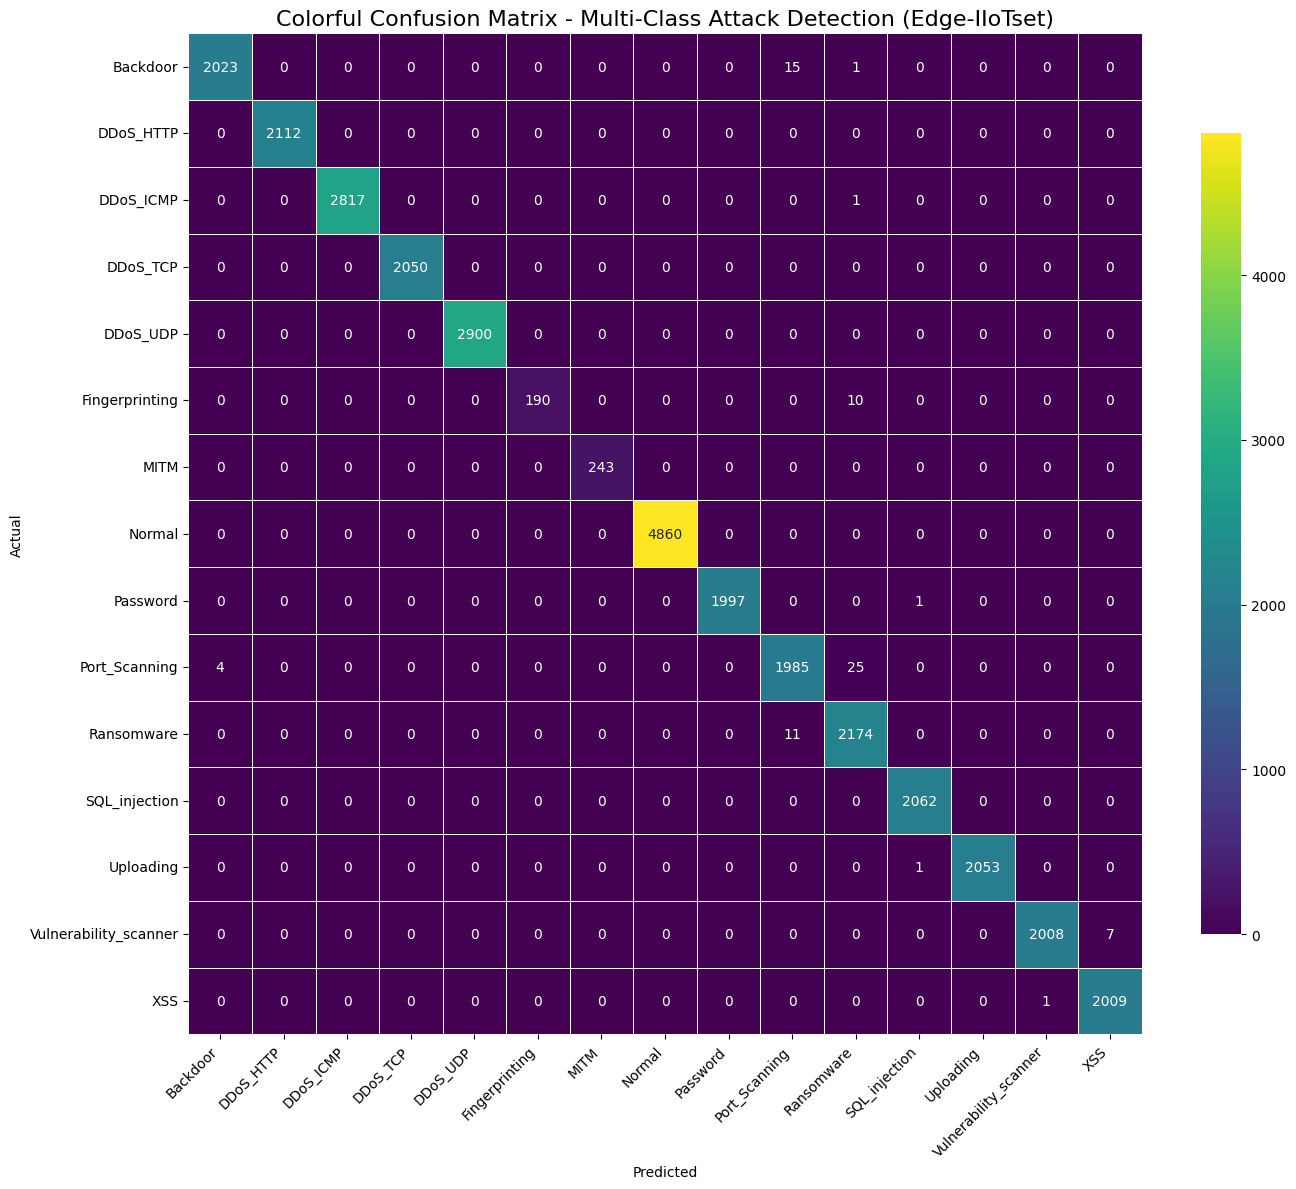

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have y_test_classes_mc and y_pred_classes_mc from multi-class
cm = confusion_matrix(y_test_classes_mc, y_pred_classes_mc)

plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis' or 'Blues' or 'plasma', 
            xticklabels=le_attack.classes_, yticklabels=le_attack.classes_,
            linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Colorful Confusion Matrix - Multi-Class Attack Detection (Edge-IIoTset)', fontsize=16)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

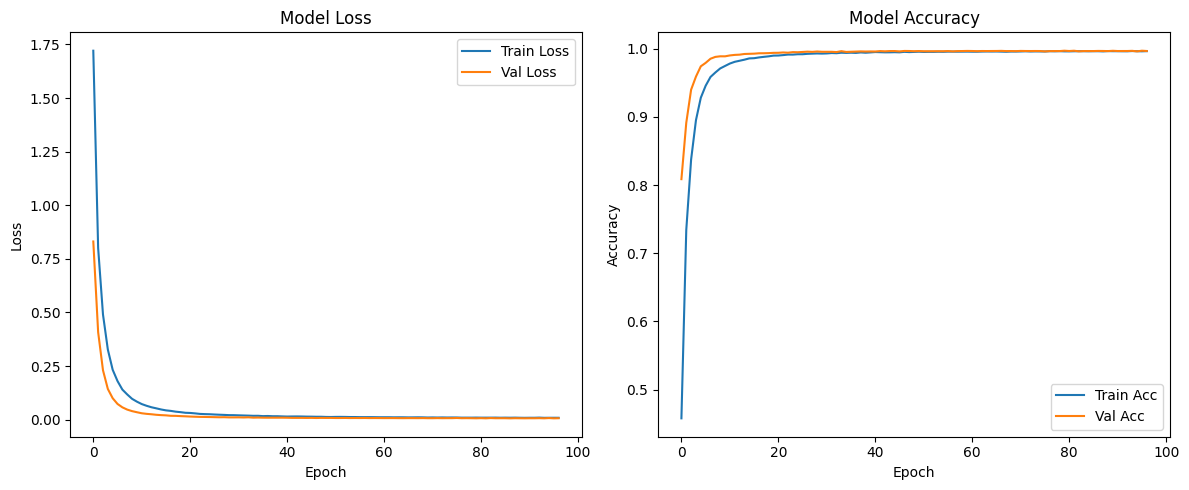

In [26]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_mc.history['loss'], label='Train Loss')
plt.plot(history_mc.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_mc.history['accuracy'], label='Train Acc')
plt.plot(history_mc.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

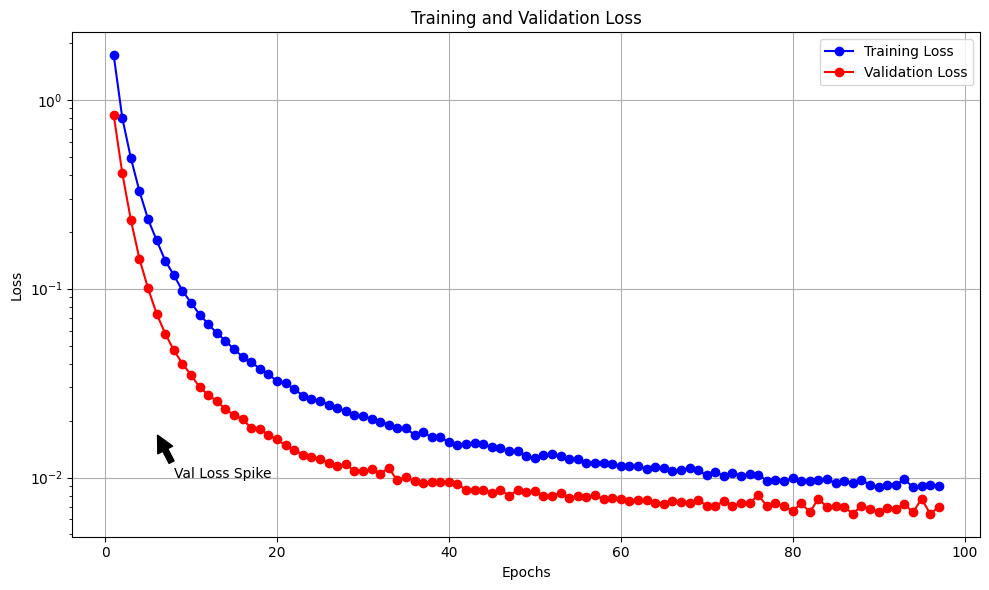

In [27]:
import matplotlib.pyplot as plt

# From your history_mc (replace with actual if different)
train_loss = history_mc.history['loss']
val_loss = history_mc.history['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')  # Log scale to better see small values and the spike
plt.legend()
plt.grid(True)
plt.annotate('Val Loss Spike', xy=(6, 0.0171), xytext=(8, 0.01),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.tight_layout()
plt.show()

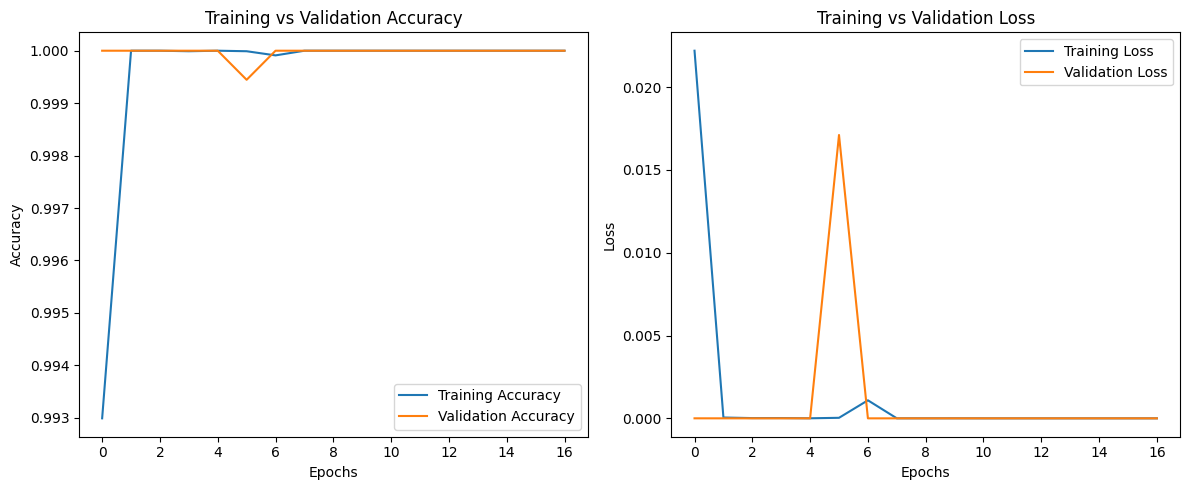

In [30]:
import matplotlib.pyplot as plt

# Plot Accuracy and Loss together
plt.figure(figsize=(12, 5))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()
